### Install needs

In [127]:
# pip install biopython bio networkx

### Imports

In [128]:
# from Bio import SeqIO
from collections import defaultdict
# from networkx.drawing.nx_pydot import graphviz_layout
# import matplotlib.pyplot as plt
from itertools import product
from scipy.linalg import expm
from Bio import Phylo
import networkx as nx
import numpy as np
import math

### Stockholm to Phylip format conversion
https://www.hiv.lanl.gov/content/sequence/FORMAT_CONVERSION/form.html

### Get Maximum Likelihood phylogenetic tree
http://www.atgc-montpellier.fr/phyml/

### Get From files

##### Sequences

In [129]:
def read_sequences (filename: str):
    first_ln = False
    num_seq = 0
    len_seq = 0
    
    seq_dict = defaultdict(str)
    
    with open(filename) as file:
        for line in file:
            line = line.strip().split()
            if len(line) == 2:
                if first_ln == False:
                    num_seq = int(line[0])
                    len_seq = int(line[1])
                    first_ln = True
                else:
                    if len(line[1]) == len_seq and num_seq != 0:
                        seq_dict[line[0]] = line[1]
                        num_seq -= 1
                    else: 
                        raise ValueError("Invalid file structure")
    return seq_dict

##### Tree

In [130]:
def clade_names_fix(tree):
    for index, clade in enumerate(tree.find_clades()):
        if not clade.name:
            if index == 0:
                clade.name = "root"
            else:
                clade.name = str(index)

def read_tree(filename: str):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    return Phylo.to_networkx(Tree)

##### Structure

In [131]:
def read_structure(filename: str):
    with open(filename) as file:
        return file.readline().strip()

In [132]:
def simplify_struct(structure: str, filename=""):
    pairing_chars = ["<", ">", "(", ")", "[", "]", "{", "}"]
    simplified = ""
    for i in range(len(structure)):
        if structure[i] in pairing_chars:
            simplified += "d "
        else:
            simplified += "s "
    if filename != "":        
        with open(f"{filename}.train", "w+") as file:
            file.write(simplified)
    
    return simplified

### Validate Sequence String

In [133]:
def is_valid_chars(input_string, valid_characters):
    for char in input_string:
        if char not in valid_characters:
            return False
    return True

### Calculate frequency

In [134]:
def calc_frequencies (seq_dict: defaultdict, structure, legal_chars = ["A", "C", "G", "U", "-"]):
    single_nucleotides = defaultdict(int)
    paired_nucleotides = defaultdict(int)
    
    total_singles = 0
    total_paireds = 0
    
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    unpaired_nucleotides = []
    
    for _, sequence in seq_dict.items():
        for index, nucleotide in enumerate(sequence): 
            if structure[index] in [p[0] for p in pairing_chars]:
                unpaired_nucleotides.append((structure[index], nucleotide))
            elif structure[index] in [p[1] for p in pairing_chars]:
                char_index = [idx for idx, val in enumerate(pairing_chars) if val[1] == structure[index]][0]
                unpaired_nucleotide = unpaired_nucleotides.pop()
                if unpaired_nucleotide[0] == pairing_chars[char_index][0]:
                    paired_nucleotide = unpaired_nucleotide[1] + nucleotide
                    if is_valid_chars(paired_nucleotide, legal_chars):
                        paired_nucleotides[unpaired_nucleotide[1] + nucleotide] += 1
                        paired_nucleotides[nucleotide + unpaired_nucleotide[1]] += 1
                        total_paireds += 1
            else:
                if is_valid_chars(nucleotide, legal_chars):
                    single_nucleotides[nucleotide] += 1
                    total_singles += 1
    
    total = total_singles + total_paireds
                
    for key, value in single_nucleotides.items():
        single_nucleotides[key] = value / total_singles
    for key, value in paired_nucleotides.items():
        paired_nucleotides[key] = value / total_paireds
        
    return single_nucleotides, paired_nucleotides, total_singles / total, total_paireds / total

### Find time two sequences

In [135]:
def find_node_by_name(graph, name_str):
    return [node for _, node in enumerate(list(graph.nodes)) if node.name==name_str][0]

In [136]:
def calculate_time(graph, sourceName, targetName):
    return nx.shortest_path_length(
            graph, 
            source= find_node_by_name(graph, sourceName), 
            target= find_node_by_name(graph, targetName), 
            weight= "weight"
        )

### Simularity Percentage

In [137]:
def check_simularity(seq1:str, seq2:str):
    simularity = 0
    if len(seq1) == len(seq2):
        for i in range(len(seq1)):
            if seq1[i] == seq2[i]:
                simularity += 1
        return simularity / len(seq1) >= .85

### Calculate Rate Matrix
$$r_{XY}=\frac{c_{XY}}{2p_xP_s\sum_{P} N_Pt_P}$$

In [138]:
def calc_rate_values(graph, seq_dict: defaultdict, structure, single_frequencies, paired_frequencies, singles_prob, paireds_prob, legal_chars = ["A", "C", "G", "U", "-"]):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    seq_list = [(k, v) for k, v in seq_dict.items()]
    tp_sumation = 0
    unpaired_nucleotides = []
    
    single_mutation_count = defaultdict(float)
    paired_mutation_count = defaultdict(float)
    
    for i in range(len(seq_list)):
        temp_single_mutation_count = defaultdict(int)
        temp_paired_mutation_count = defaultdict(int)
        
        same_first_sequence_count = 0
        
        for j in range(len(seq_list)):
            if i != j and check_simularity(seq_list[i][1], seq_list[j][1]):
                same_first_sequence_count += 1
                for k in range(len(seq_list[i][1])): 
                    if structure[k] in [p[0] for p in pairing_chars]:
                        unpaired_nucleotides.append((structure[k], seq_list[i][1][k], seq_list[j][1][k]))
                    elif structure[k] in [p[1] for p in pairing_chars]:
                        char_index = [idx for idx, val in enumerate(pairing_chars) if val[1] == structure[k]][0]
                        unpaired_nucleotide = unpaired_nucleotides.pop()
                        if unpaired_nucleotide[0] == pairing_chars[char_index][0]:
                            if seq_list[i][1][k] + unpaired_nucleotide[1] != seq_list[j][1][k] + unpaired_nucleotide[2]:
                                if is_valid_chars(seq_list[i][1][k] + unpaired_nucleotide[1], legal_chars) and is_valid_chars(seq_list[j][1][k] + unpaired_nucleotide[2], legal_chars):
                                    temp_paired_mutation_count[(seq_list[i][1][k] + unpaired_nucleotide[1], seq_list[j][1][k] + unpaired_nucleotide[2])] += 1
                                    temp_paired_mutation_count[(unpaired_nucleotide[1] + seq_list[i][1][k], unpaired_nucleotide[2] + seq_list[j][1][k])] += 1
                    else:
                        if seq_list[i][1][k] != seq_list[j][1][k]:
                            if is_valid_chars(seq_list[i][1][k], legal_chars) and is_valid_chars(seq_list[j][1][k], legal_chars):
                                temp_single_mutation_count[(seq_list[i][1][k], seq_list[j][1][k])] += 1
                tp_sumation += calculate_time(graph, seq_list[i][0], seq_list[j][0])
    
        if same_first_sequence_count > 0:
            for key in temp_single_mutation_count:
                single_mutation_count[key] += temp_single_mutation_count[key] / same_first_sequence_count
            for key in temp_paired_mutation_count:
                paired_mutation_count[key] += temp_paired_mutation_count[key] / same_first_sequence_count
                
    single_chars = legal_chars
    paired_chars = [c1 + c2 for c1 in single_chars for c2 in single_chars]
    
    single_rate_values = defaultdict(float)
    paired_rate_values = defaultdict(float)
            
    for i in single_chars:
        single_rate_values[(i,i)] = 0
        for j in single_chars:
            if i != j:
                single_rate_values[(i,j)] = single_mutation_count[(i,j)] / (singles_prob * single_frequencies[i] * tp_sumation * len(structure))
                single_rate_values[(i,i)] = single_rate_values[(i,i)] - single_rate_values[(i,j)]
    for i in paired_chars:
        paired_rate_values[(i,i)] = 0
        for j in paired_chars:
            if i != j:
                paired_rate_values[(i,j)] = paired_mutation_count[(i,j)] / (paireds_prob * paired_frequencies[i] * tp_sumation * len(structure))
                paired_rate_values[(i,i)] = paired_rate_values[(i,i)] - paired_rate_values[(i,j)]
    
    return single_rate_values, paired_rate_values  

### Probablity From Q matrix

$$P = e^{Qt}$$

In [139]:
def get_probablity_values(mutation_rate_values, time, order_array):
    mutation_rate_matrix = np.zeros((len(order_array), len(order_array)), np.float64)
    
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            mutation_rate_matrix[i_index,j_index] = mutation_rate_values[(i_value, j_value)]
    
    probablity_rate_matrix = expm(mutation_rate_matrix * time)
    
    probablity_rate_values = defaultdict(float)
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            probablity_rate_values[(i_value, j_value)] = probablity_rate_matrix[i_index,j_index]
    
    return probablity_rate_values

### Calculate Column Probablity

In [140]:
def get_subtree(graph, leafs):
    subtree_nodes = []
    leaf_nodes = []
    unleaf_nodes = []
    
    for i in range(len(leafs)):
        leaf_nodes.append(find_node_by_name(graph, leafs[i]))
        for j in range(i+1, len(leafs)):
            path = nx.shortest_path(
                graph, 
                find_node_by_name(graph, leafs[i]), 
                find_node_by_name(graph, leafs[j]))
            for node in path:
                if not node in subtree_nodes:
                    subtree_nodes.append(node)
                    if not node.name in leafs:
                        unleaf_nodes.append(node)              
    
    subgraph = graph.subgraph(subtree_nodes)
    
    subgraph_root = None
    min_distance = float("inf")
    
    for node in subgraph.nodes:
        new_distance = nx.shortest_path_length(
            graph, 
            source= node,
            target= find_node_by_name(graph, "root"), 
        )
        if new_distance < min_distance:
            subgraph_root = node
            min_distance = new_distance
        
    return subgraph, subgraph_root, leaf_nodes, unleaf_nodes

In [141]:
def get_all_states(n, paired=False):
    single_chars = ['A', 'C', 'G', 'U', '-']
    paired_chars = [c1 + c2 for c1 in single_chars for c2 in single_chars]
    
    if paired == False:
        return [p for p in product(single_chars, repeat = n)]
    else:
        return [p for p in product(paired_chars, repeat = n)]
        

In [142]:
def sort_nodes_on_edge (graph, edge, root):
    if nx.shortest_path_length(
        graph, 
        source= edge[0],
        target= root, 
    ) < nx.shortest_path_length(
        graph, 
        source= edge[1],
        target= root, 
    ) :
        return edge[0], edge[1]
    return edge[1], edge[0]

In [143]:
def calc_column_prob(graph, frequencies, rate_values, aligned_list, leaf_values):
    subgraph, subgraph_root, leaf_nodes, unleaf_nodes = get_subtree(graph, aligned_list)
    
    column_probablity = 0
        
    unleaf_values_list = get_all_states(len(unleaf_nodes))
    for unleaf_values in unleaf_values_list:
        temp = 1
        for edge in subgraph.edges():
            down_value = None
            up_node, down_node = sort_nodes_on_edge(subgraph, edge, subgraph_root)
            
            if down_node in leaf_nodes:
                down_value = leaf_values[leaf_nodes.index(down_node)]
            else:
                down_value = unleaf_values[unleaf_nodes.index(down_node)]
            up_value = unleaf_values[unleaf_nodes.index(up_node)]
            
            time = nx.shortest_path_length(
                graph,
                source= up_node,
                target= down_node,
                weight= "weight"
            )
            probablity_values = get_probablity_values(rate_values, time, ["A", "C", "G", "U", "-"])
            temp *= probablity_values[(up_value, down_value)]
        
        root_value = None
        if subgraph_root in leaf_nodes:
            root_value = leaf_values[leaf_nodes.index(subgraph_root)]
        else:
            root_value = unleaf_values[unleaf_nodes.index(subgraph_root)]
        
        column_probablity += (temp * frequencies[root_value])
        
    return column_probablity

In [144]:
def get_column_probs(graph, frequencies, rate_values, aligned_list):
    column_probs = defaultdict(float)
    leaf_values_list = get_all_states(len(aligned_list))
    
    for leaf_values in leaf_values_list:
        column_probs[tuple(leaf_values)] = calc_column_prob(graph, frequencies, rate_values, aligned_list, leaf_values)
    
    return column_probs

### Estimate PCFG on structure

defaultdict(<class 'float'>, {('S', 'L', 'S'): 0.7368421052631579, ('S', 'Dt', 'Do'): 0.052631578947368446, ('F', 'Dt', 'Do'): 0.6818181818181818, ('F', 'L', 'S'): 0.3181818181818182, ('L', 'Dt', 'Do'): 0.14285714285714288, ('Dt', 'Do', 'F'): 1.0, ('S', 's'): 0.21052631578947367, ('L', 's'): 0.8571428571428571, ('Do', 'd'): 1.0})
s


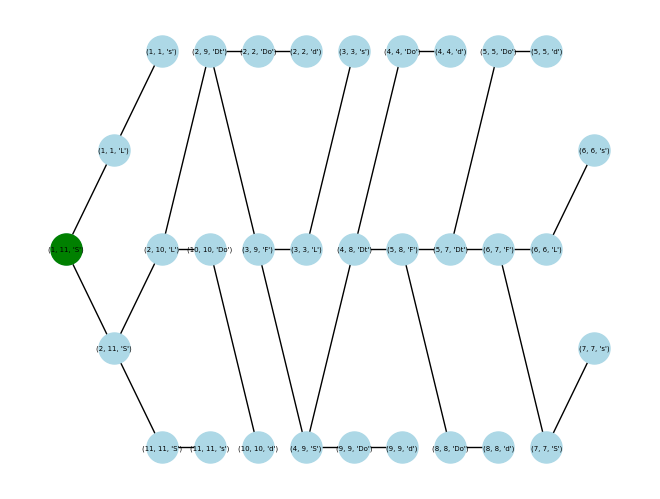

In [145]:
from grammar.pcfg import PCFG

pcfg = PCFG("Structure.cfg", "Structure.pcfg")
print(pcfg.gen_sentence("S"))
probablity, table = pcfg.sentence_prob("s d s d d s s d d d s ")
parse_tree = nx.Graph()

def draw_parse_tree(graph, table, start, end, non_terminal = "S", firstRun = True, layer=1):
    if firstRun:
        parse_tree.add_node((start, end, "S"), layer=layer)
        layer += 1
    for _start, _end, _non_terminal in table[(start, end, non_terminal)]:
        graph.add_node((_start, _end, _non_terminal), layer=layer)
        new_layer = layer + 1
        graph.add_edge((_start, _end, _non_terminal), (start, end, non_terminal))
        draw_parse_tree(graph, table, _start, _end, _non_terminal, firstRun=False, layer=new_layer)

draw_parse_tree(parse_tree, table, 1, 11)

pos = nx.multipartite_layout(parse_tree, subset_key ="layer")
nx.draw(parse_tree, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=5)
nx.draw_networkx_nodes(parse_tree, pos, nodelist=[(1, 11, "S")], node_color='green', node_size=500)

# plt.savefig("plot.png", dpi=1000)
# q = pcfg.estimate(5)

In [146]:
# unary_rules = pcfg.grammar.unary_rules
# binary_rules = pcfg.grammar.binary_rules

# for A, B, C in binary_rules:
#     print(A + " -> " + B + " " + C + " " + str(q.get((A, B, C))))

# for A, w in unary_rules:
#     print(A + " -> " + w + " " + str(q.get((A, w))))

### Test

In [147]:
structure = read_structure("RF03000.structure")
seq_dict = read_sequences("RF03000.phylip")
graph = read_tree("RF03000.nwk")
simplified = simplify_struct(structure, "RF03000")

single_frequencies, paired_frequencies, singles_prob, paireds_prob = calc_frequencies(seq_dict, structure)
single_rate_values, paired_rate_values = calc_rate_values(graph, seq_dict, structure, single_frequencies, paired_frequencies, singles_prob, paireds_prob)


aligned_list = ["URS0000D68222_12908/1-125", "URS0000D6D017_12908/1-124"]
get_column_probs(graph, single_frequencies, single_rate_values, aligned_list)
# get_probablity_values(single_rate_matrix, .05, ["A", "C", "G", "U"])


defaultdict(float,
            {('A', 'A'): 0.14973381320252302,
             ('A', 'C'): 0.00030465097286275943,
             ('A', 'G'): 0.00035313475153585434,
             ('A', 'U'): 0.00035972154687912263,
             ('A', '-'): 0.00033266069806326147,
             ('C', 'A'): 0.0003038897450194204,
             ('C', 'C'): 0.05662288316884487,
             ('C', 'G'): 9.827558121371216e-05,
             ('C', 'U'): 0.0005482087867699052,
             ('C', '-'): 0.00019665985723995043,
             ('G', 'A'): 0.0003539627691910678,
             ('G', 'C'): 9.847500748223076e-05,
             ('G', 'G'): 0.04818207054811879,
             ('G', 'U'): 0.00016896274113679802,
             ('G', '-'): 0.00020734332640152476,
             ('U', 'A'): 0.0003575245534455078,
             ('U', 'C'): 0.0005485724239012909,
             ('U', 'G'): 0.00017227790762591817,
             ('U', 'U'): 0.08413510563457789,
             ('U', '-'): 0.0003078344597175607,
             ('-', 'A